In [1]:
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("yolov3.cfg","yolov3_1200.weights")
layer_names = net.getLayerNames()
# get layers
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
classes = [line.strip() for line in open("mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]

def yolo_detect(frame):
    # forward propogation
    img = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape 
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # get boxes
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            # first 5 are Box Co-ordinates and score(object)
            tx, ty, tw, th, confidence = detection[0:5]
            # 678 are class scores
            scores = detection[5:]
            # choose highest class score
            class_id = np.argmax(scores)  
            if confidence > 0.3: 
                # get object center and width height
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)            
                # get x y
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                #save object Co-ordinates ,confidences and class
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(boxes)):
        if i in indexes:
            # in indexes,get x, y, w, h, label, color
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            # write rectangle and Text(good,bad,none)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y - 5), font, 0.7, color, 2, cv2.LINE_AA)
    return img

### test

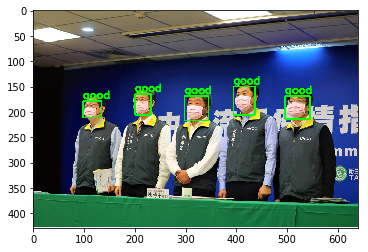

In [8]:
from matplotlib import pyplot as plt
img = cv2.imread("test.jpg")
im = yolo_detect(img)
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

### last step! cv2

In [2]:
import cv2
import imutils
import time

VIDEO_IN = cv2.VideoCapture(0)

while True:
    hasFrame, frame = VIDEO_IN.read()
    
    img = yolo_detect(frame)
    cv2.imshow("Frame", imutils.resize(img, width=850))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
